In [21]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [22]:
file = pd.read_csv('../model_data.csv')

In [23]:
file = file.fillna(0)

In [24]:
file = file.drop(columns=['num_tweets'])

### Preprocessing
- Minor changes needed. 
- Convert 'created_at' to datetime
- Convert 'collection_name' to ints

In [25]:
# Manually convert collection_name into nums
collections = {}
count = 1
for col in file['collection_name'].unique():
    collections[col] = count
    count += 1
    
file['collection_name'] = file['collection_name'].apply(lambda x: collections[x])

In [26]:
# Convert to datetime
file['created_at'] = file['created_at'].apply(lambda x: pd.to_datetime(x))
file = file.set_index('created_at')

In [27]:
file.dtypes

final_vader_score         float64
prices_scaled             float64
previous_day_sentiment    float64
trends                    float64
trends_previous_day       float64
trends_two_days_prior     float64
collection_name             int64
dtype: object

# Let's do some MODELING

## Create Train and Test data

In [28]:
init_df = file[file['collection_name']==1].copy()

In [29]:
(X, y) = (np.array(init_df.drop(columns=['prices_scaled'])), np.array(init_df['prices_scaled']))

In [30]:
# from sklearn.model_selection import train_test_split

# def split_data(data, test_size):
#     (X_temp, y_temp) = (np.array(data.drop(columns=['prices_scaled'])), np.array(data['prices_scaled']))
#     X_train_temp, X_test_temp, y_train_temp, y_test_temp = train_test_split(X_temp, y_temp, test_size=0.2, random_state=699)
#     return(X_train_temp, X_test_temp, y_train_temp, y_test_temp)

# Source: https://medium.com/keita-starts-data-science/time-series-split-with-scikit-learn-74f5be38489e
def split_data(data, test_size):
    X = data.drop(columns=['prices_scaled'])
    y = data['prices_scaled']
    X_train = X[:int(data.shape[0]*(test_size/100))]
    X_test = X[int(data.shape[0]*(test_size/100)):]
    y_train = y[:int(data.shape[0]*(test_size/100))]
    y_test = y[int(data.shape[0]*(test_size/100)):]
    return(X_train, X_test, y_train, y_test)

In [31]:
def create_test_train(df, test_size):
    collection_names = df['collection_name'].unique()
    main_data = split_data(df[df['collection_name']==collection_names[0]], test_size)
    X_train = main_data[0]
    X_test = main_data[1]
    y_train = main_data[2]
    y_test = main_data[3]
    
    for collection_name in collection_names[1:]:
        try:
            new_data = split_data(df[df['collection_name']==collection_name], test_size)
            X_train = X_train.append(new_data[0])
            X_test = X_test.append(new_data[1])
            y_train = y_train.append(new_data[2])
            y_test = y_test.append(new_data[3])
        except ValueError:
            print("ERROR:")
            for item in collections.items():
                if item[1]==collection_name:
                    print(item)
            pass
#     X_train = np.array(X_train)
#     X_test = np.array(X_test)
#     y_train = np.array(y_train)
#     y_test = np.array(y_test)
    return(X_train, X_test, y_train, y_test)

In [32]:
test = create_test_train(file, 80)

In [33]:
X_train = test[0].reset_index(drop=True)
X_test = test[1].reset_index(drop=True)
y_train = test[2].reset_index(drop=True)
y_test = test[3].reset_index(drop=True)

In [34]:
# Creating a 20% sample to speed up initial model generation
X_train_sample = X_train.sample(n=int((X_train.shape[0])*.2), random_state=699)
y_train_sample = y_train.iloc[X_train_sample.index]

## ARIMA

Source: https://builtin.com/data-science/time-series-forecasting-python

In [35]:
from sklearn.metrics import mean_squared_error

In [36]:
import warnings
warnings.filterwarnings("ignore")

In [37]:
# !pip install pmdarima
from pmdarima.arima import auto_arima

In [38]:
# Source: https://towardsdatascience.com/time-series-forecasting-using-auto-arima-in-python-bb83e49210cd
arima_model = auto_arima(y_train, start_p=0, d=1, start_q=0,
                        max_p=5, max_d=5, max_q=5, start_P=0,
                        D=1, start_Q=0, max_P=5, max_D=5,
                        max_Q=5, m=12, seasonal=False, error_action='warn',
                         trace=True, suppress_warnings=True, stepwise=True,
                        random_state=699, n_fits=50)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=9157.901, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=8936.400, Time=0.13 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=8736.483, Time=0.22 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=9155.907, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=1.27 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=8570.003, Time=0.37 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=1.88 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=8518.860, Time=0.79 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=2.14 sec
 ARIMA(0,1,4)(0,0,0)[0] intercept   : AIC=inf, Time=2.34 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=8467.689, Time=2.64 sec
 ARIMA(2,1,4)(0,0,0)[0] intercept   : AIC=inf, Time=3.04 sec
 ARIMA(1,1,5)(0,0,0)[0] intercept   : AIC=inf, Time=3.34 sec
 ARIMA(0,1,5)(0,0,0)[0] intercept   : AIC=inf, Time=2.88 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=2.42 sec
 ARIMA(

In [39]:
arima_preds = arima_model.predict(y_test.shape[0])

arma_rmse = np.sqrt(mean_squared_error(y_test, arima_preds))
print("RMSE: ",arma_rmse)

RMSE:  0.8486916351080254


Conclusion: ARIMA is not bad!

## Linear Regression

In [40]:
from sklearn.model_selection import GridSearchCV

In [41]:
# Import
from sklearn.linear_model import LinearRegression

In [42]:
# Generate base model
lin_model = LinearRegression().fit(X_train, y_train)

Use GridSearchCV to find the best hyper-parameters

In [43]:
parameter_options = {'fit_intercept':['True', 'False'],
                     'copy_X':['True', 'False']}

In [44]:
lin_grid = GridSearchCV(lin_model, parameter_options, cv = 3)

In [45]:
lin_grid.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=LinearRegression(),
             param_grid={'copy_X': ['True', 'False'],
                         'fit_intercept': ['True', 'False']})

In [46]:
# print best parameters
print(lin_grid.best_params_)

{'copy_X': 'True', 'fit_intercept': 'True'}


In [47]:
# Model generation with the best parameters
lin_model = LinearRegression(copy_X=True, fit_intercept=True)
lin_model.fit(X_train, y_train)

LinearRegression()

In [48]:
# Prediction
y_test_pred_lin = lin_model.predict(X_test)

### SVM

In [51]:
# Import
from sklearn.svm import LinearSVR

In [52]:
# Generate base model
svm_model = LinearSVR().fit(X_train_sample, y_train_sample)

GridSearchCV to find the best parameters

In [61]:
parameter_options = {'epsilon':[0.0, 0.1, 0.25, 0.5],
                     'loss':['epsilon_insensitive', 'squared_epsilon_insensitive'],
                     'fit_intercept':['True', 'False']}

In [62]:
svm_grid = GridSearchCV(svm_model, parameter_options, cv=5)

In [63]:
svm_grid.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=LinearSVR(),
             param_grid={'epsilon': [0.0, 0.1, 0.25, 0.5],
                         'fit_intercept': ['True', 'False'],
                         'loss': ['epsilon_insensitive',
                                  'squared_epsilon_insensitive']})

In [64]:
# print best parameters
print(svm_grid.best_params_)

{'epsilon': 0.5, 'fit_intercept': 'True', 'loss': 'epsilon_insensitive'}


Applying the best parameters to the new SVM

In [65]:
# Best model for SVM
svm_model = LinearSVR(epsilon=0.5, fit_intercept=True, loss='squared_epsilon_insensitive', random_state=699)
svm_model.fit(X_train_sample, y_train_sample)

LinearSVR(epsilon=0.5, loss='squared_epsilon_insensitive', random_state=699)

In [66]:
y_test_pred_svm = svm_model.predict(X_test)

### RandomForest Regressor

In [67]:
# Import
from sklearn.ensemble import RandomForestRegressor

In [68]:
# Generate base model
rf_model = RandomForestRegressor(random_state=699)

GridSearchCV

In [76]:
parameter_options = {'n_estimators':[10, 50, 100],
                     'min_samples_split':[0.5, 1, 1.5, 2, 3],
                     'min_samples_leaf':[0.1, 0.5, 1, 2]
                    }

In [77]:
rf_grid = GridSearchCV(rf_model, parameter_options, cv=5)

In [78]:
rf_grid.fit(X_train_sample, X_train_sample)

GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=699),
             param_grid={'min_samples_leaf': [0.1, 0.5, 1, 2],
                         'min_samples_split': [0.5, 1, 1.5, 2, 3],
                         'n_estimators': [10, 50, 100]})

In [79]:
# print best parameters
print(rf_grid.best_params_)

{'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 10}


In [80]:
# Using best paramters to create the model
rf_model = RandomForestRegressor(n_estimators=10, min_samples_leaf=2, min_samples_split=2,
                                 random_state=699)

In [81]:
rf_model.fit(X_train, y_train)

RandomForestRegressor(min_samples_leaf=2, n_estimators=10, random_state=699)

In [82]:
y_test_pred_rf = rf_model.predict(X_test)

### SGDRegressor

In [83]:
# Import
from sklearn.linear_model import SGDRegressor

In [84]:
# Generate base model
sgdr_model = SGDRegressor(random_state=699)

GridSearchCV

In [85]:
parameters = {'alpha': [0.0001, 0.001, 0.01, 0.1, 0.5, 0.99],
             'l1_ratio':[0.0001, 0.001, 0.01, 0.1, 0.25, 0.5, 0.75, 0.9],
             'penalty':['l1', 'l2', 'elasticnet'],
             'epsilon':[0.001, 0.01, 0.1, 0, -0.1]}

In [86]:
sgd_grid = GridSearchCV(sgdr_model, parameters)

In [87]:
sgd_grid.fit(X_train, y_train)

GridSearchCV(estimator=SGDRegressor(random_state=699),
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.1, 0.5, 0.99],
                         'epsilon': [0.001, 0.01, 0.1, 0, -0.1],
                         'l1_ratio': [0.0001, 0.001, 0.01, 0.1, 0.25, 0.5, 0.75,
                                      0.9],
                         'penalty': ['l1', 'l2', 'elasticnet']})

In [88]:
# print best parameters
print(sgd_grid.best_params_)

{'alpha': 0.99, 'epsilon': 0.001, 'l1_ratio': 0.0001, 'penalty': 'l2'}


In [89]:
# Implement the best hyper-parameters
sgdr_model = SGDRegressor(random_state=699, alpha=0.99, epsilon=0.001, l1_ratio=0.0001,
                          penalty='l2')
sgdr_model.fit(X_train, y_train)

SGDRegressor(alpha=0.99, epsilon=0.001, l1_ratio=0.0001, random_state=699)

In [90]:
y_test_pred_sgdr = sgdr_model.predict(X_test)

## KNN

Source: https://www.analyticsvidhya.com/blog/2018/08/k-nearest-neighbor-introduction-regression-python/

In [91]:
#import required packages
from sklearn import neighbors
from sklearn.metrics import mean_squared_error 
from math import sqrt
import matplotlib.pyplot as plt
%matplotlib inline

In [92]:
rmse_val = [] #to store rmse values for different k
ideal_k = 1
K = 1
knn_model = neighbors.KNeighborsRegressor(n_neighbors = K)
knn_model.fit(X_train, y_train)
pred=knn_model.predict(X_test) 
min_rmse = sqrt(mean_squared_error(y_test,pred))


for K in range(2, 20):
    knn_model = neighbors.KNeighborsRegressor(n_neighbors = K)
    knn_model.fit(X_train, y_train)
    pred=knn_model.predict(X_test)
    error = sqrt(mean_squared_error(y_test,pred))
    if error < min_rmse:
        min_rmse = error
        ideal_k = K   

In [93]:
print(ideal_k, min_rmse)

19 0.9090719555549138


In [94]:
#predicting on the test set and creating submission file

knn_model = neighbors.KNeighborsRegressor(n_neighbors = ideal_k)

knn_model.fit(X_train, y_train)  #fit the model
knn_y_pred=knn_model.predict(X_test) #make prediction on test set
knn_rmse = sqrt(mean_squared_error(y_test,pred))

# submission.to_csv('submit_file.csv',index=False)

## XGBoost

In [98]:
# pip install xgboost

In [99]:
import xgboost as xgb

In [100]:
xgb_model = xgb.XGBRegressor()
xgb_model.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)

In [101]:
xgb_preds = xgb_model.predict(X_test)

## MLP
Source: https://www.kaggle.com/code/dimitreoliveira/deep-learning-for-time-series-forecasting/notebook

In [102]:
from tensorflow import keras
from keras import optimizers
from keras.models import Sequential, Model
from keras.layers import Dense, LSTM, RepeatVector, TimeDistributed, Flatten

In [103]:
epochs = 40
batch = 256
lr = 0.0003
adam = keras.optimizers.Adam(lr)

In [104]:
model_mlp = Sequential()
model_mlp.add(Dense(100, activation='relu', input_dim=X_train.shape[1]))
model_mlp.add(Dense(1))
model_mlp.compile(loss='mse', optimizer=adam)


In [105]:
mlp = model_mlp.fit(X_train.values, y_train, validation_data=(X_test.values, y_test), epochs=epochs, verbose=2)

Epoch 1/40
83/83 - 0s - loss: 23883.1816 - val_loss: 11921.5205 - 491ms/epoch - 6ms/step
Epoch 2/40
83/83 - 0s - loss: 18356.9570 - val_loss: 10595.3799 - 88ms/epoch - 1ms/step
Epoch 3/40
83/83 - 0s - loss: 8098.4966 - val_loss: 15715.3242 - 85ms/epoch - 1ms/step
Epoch 4/40
83/83 - 0s - loss: 6755.8545 - val_loss: 9804.0342 - 94ms/epoch - 1ms/step
Epoch 5/40
83/83 - 0s - loss: 2666.5977 - val_loss: 2443.7703 - 89ms/epoch - 1ms/step
Epoch 6/40
83/83 - 0s - loss: 2341.1602 - val_loss: 3302.3113 - 85ms/epoch - 1ms/step
Epoch 7/40
83/83 - 0s - loss: 1105.3965 - val_loss: 1573.7826 - 89ms/epoch - 1ms/step
Epoch 8/40
83/83 - 0s - loss: 924.6469 - val_loss: 334.0730 - 91ms/epoch - 1ms/step
Epoch 9/40
83/83 - 0s - loss: 432.5383 - val_loss: 984.6047 - 95ms/epoch - 1ms/step
Epoch 10/40
83/83 - 0s - loss: 263.7358 - val_loss: 226.3902 - 96ms/epoch - 1ms/step
Epoch 11/40
83/83 - 0s - loss: 173.8795 - val_loss: 301.1675 - 94ms/epoch - 1ms/step
Epoch 12/40
83/83 - 0s - loss: 159.5247 - val_loss: 11

In [106]:
mlp_train_pred = model_mlp.predict(X_train.values)
mlp_valid_pred = model_mlp.predict(X_test.values)
print('Train rmse:', np.sqrt(mean_squared_error(y_train, mlp_train_pred)))
print('Validation rmse:', np.sqrt(mean_squared_error(y_test, mlp_valid_pred)))

Train rmse: 8.505474096928408
Validation rmse: 3.5450031825831694


## CNN
Source: https://www.kaggle.com/code/dimitreoliveira/deep-learning-for-time-series-forecasting/notebook

In [107]:
from keras.layers.convolutional import Conv1D, MaxPooling1D

In [108]:
X_train_series = X_train.values.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test_series = X_test.values.reshape((X_test.shape[0], X_test.shape[1], 1))

In [109]:
model_cnn = Sequential()
model_cnn.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(X_train_series.shape[1], X_train_series.shape[2])))
model_cnn.add(MaxPooling1D(pool_size=2))
model_cnn.add(Flatten())
model_cnn.add(Dense(50, activation='relu'))
model_cnn.add(Dense(1))
model_cnn.compile(loss='mse', optimizer=adam)


In [110]:
cnn = model_cnn.fit(X_train_series, y_train, validation_data=(X_test_series, y_test), epochs=epochs, verbose=2)

Epoch 1/40
83/83 - 0s - loss: 66092.9609 - val_loss: 2564.5659 - 493ms/epoch - 6ms/step
Epoch 2/40
83/83 - 0s - loss: 31762.4922 - val_loss: 15021.7148 - 124ms/epoch - 1ms/step
Epoch 3/40
83/83 - 0s - loss: 19622.7480 - val_loss: 5482.6777 - 107ms/epoch - 1ms/step
Epoch 4/40
83/83 - 0s - loss: 11702.3330 - val_loss: 1317.8990 - 124ms/epoch - 1ms/step
Epoch 5/40
83/83 - 0s - loss: 5075.2915 - val_loss: 481.1804 - 103ms/epoch - 1ms/step
Epoch 6/40
83/83 - 0s - loss: 3212.7029 - val_loss: 1155.7855 - 93ms/epoch - 1ms/step
Epoch 7/40
83/83 - 0s - loss: 807.8300 - val_loss: 79.1602 - 100ms/epoch - 1ms/step
Epoch 8/40
83/83 - 0s - loss: 427.8583 - val_loss: 543.7784 - 102ms/epoch - 1ms/step
Epoch 9/40
83/83 - 0s - loss: 300.8108 - val_loss: 124.0077 - 86ms/epoch - 1ms/step
Epoch 10/40
83/83 - 0s - loss: 520.7219 - val_loss: 171.2926 - 93ms/epoch - 1ms/step
Epoch 11/40
83/83 - 0s - loss: 313.7310 - val_loss: 184.0774 - 99ms/epoch - 1ms/step
Epoch 12/40
83/83 - 0s - loss: 264.2671 - val_loss: 

In [111]:
cnn_train_pred = model_cnn.predict(X_train_series)
cnn_valid_pred = model_cnn.predict(X_test_series)
print('Train rmse:', np.sqrt(mean_squared_error(y_train, cnn_train_pred)))
print('Validation rmse:', np.sqrt(mean_squared_error(y_test, cnn_valid_pred)))

Train rmse: 9.459319117446688
Validation rmse: 14.475840602574959


## LSTM
Source: https://www.kaggle.com/code/dimitreoliveira/deep-learning-for-time-series-forecasting/notebook

In [112]:
model_lstm = Sequential()
model_lstm.add(LSTM(50, activation='relu', input_shape=(X_train_series.shape[1], X_train_series.shape[2])))
model_lstm.add(Dense(1))
model_lstm.compile(loss='mse', optimizer=adam)

In [113]:
lstm = model_lstm.fit(X_train_series, y_train, validation_data=(X_test_series, y_test), epochs=epochs, verbose=2)

Epoch 1/40
83/83 - 1s - loss: 136.9458 - val_loss: 127.4596 - 1s/epoch - 13ms/step
Epoch 2/40
83/83 - 0s - loss: 210.6624 - val_loss: 61.0262 - 195ms/epoch - 2ms/step
Epoch 3/40
83/83 - 0s - loss: 44.3952 - val_loss: 1.9265 - 212ms/epoch - 3ms/step
Epoch 4/40
83/83 - 0s - loss: 20.4160 - val_loss: 1.8463 - 207ms/epoch - 2ms/step
Epoch 5/40
83/83 - 0s - loss: 7.6580 - val_loss: 3.3583 - 202ms/epoch - 2ms/step
Epoch 6/40
83/83 - 0s - loss: 4.6767 - val_loss: 6.2066 - 205ms/epoch - 2ms/step
Epoch 7/40
83/83 - 0s - loss: 5.5398 - val_loss: 1.4531 - 188ms/epoch - 2ms/step
Epoch 8/40
83/83 - 0s - loss: 2.5185 - val_loss: 1.3414 - 185ms/epoch - 2ms/step
Epoch 9/40
83/83 - 0s - loss: 4.1619 - val_loss: 1.6455 - 184ms/epoch - 2ms/step
Epoch 10/40
83/83 - 0s - loss: 7.0781 - val_loss: 3.3981 - 203ms/epoch - 2ms/step
Epoch 11/40
83/83 - 0s - loss: 3.3352 - val_loss: 9.3072 - 183ms/epoch - 2ms/step
Epoch 12/40
83/83 - 0s - loss: 4.1967 - val_loss: 9.0772 - 184ms/epoch - 2ms/step
Epoch 13/40
83/83 

In [114]:
lstm_train_pred = model_lstm.predict(X_train_series)
lstm_valid_pred = model_cnn.predict(X_test_series)
print('Train rmse:', np.sqrt(mean_squared_error(y_train, lstm_train_pred)))
print('Validation rmse:', np.sqrt(mean_squared_error(y_test, lstm_valid_pred)))

Train rmse: 2.206989385436559
Validation rmse: 14.475840602574959


## Model Evaluation and Comparison

In [115]:
from sklearn import metrics

List of models:
- ARMAmodel, 
- lin_model, 
- svm_model, 
- rf_model,
- sgdr_model, 
- knn_model

In [117]:
from sklearn.model_selection import cross_val_score

In [118]:
# Outputting all the results
print('--- ARMA --- ')
print('Mean Absolute Error (MAE): ' + str(metrics.mean_absolute_error(y_test, arima_preds)))
# print('Mean Squared Error (MSE): ' + str(metrics.mean_squared_error(y_test, y_pred_out)))
print('Root MSE (rMSE): ' + str(np.sqrt(metrics.mean_squared_error(y_test, arima_preds))))
print('\n')

print('--- Linear Regression --- ')
print('Mean Absolute Error (MAE): ' + str(metrics.mean_absolute_error(y_test, y_test_pred_lin)))
# print('Mean Squared Error (MSE): ' + str(metrics.mean_squared_error(y_test, y_test_pred_lin)))
print('Root MSE (rMSE): ' + str(np.sqrt(metrics.mean_squared_error(y_test, y_test_pred_lin))))
print('CV mean score:', cross_val_score(lin_model, X, y, cv=10).mean())
print('\n')

print('--- SVM ---')
print('Mean Absolute Error (MAE): ' + str(metrics.mean_absolute_error(y_test, y_test_pred_svm)))
# print('Mean Squared Error (MSE): ' + str(metrics.mean_squared_error(y_test, y_test_pred_svm)))
print('Root MSE (rMSE): ' + str(np.sqrt(metrics.mean_squared_error(y_test, y_test_pred_svm))))
print('CV mean score:', cross_val_score(svm_model, X, y, cv=10).mean())
print('\n')

print('--- Random Forest Regression --- ')
print('Mean Absolute Error (MAE): ' + str(metrics.mean_absolute_error(y_test, y_test_pred_rf)))
# print('Mean Squared Error (MSE): ' + str(metrics.mean_squared_error(y_test, y_test_pred_rf)))
print('Root MSE (rMSE): ' + str(np.sqrt(metrics.mean_squared_error(y_test, y_test_pred_rf))))
print('CV mean score:', cross_val_score(rf_model, X, y, cv=10).mean())
print('\n')

print('--- SGD Regression --- ')
print('Mean Absolute Error (MAE): ' + str(metrics.mean_absolute_error(y_test, y_test_pred_sgdr)))
# print('Mean Squared Error (MSE): ' + str(metrics.mean_squared_error(y_test, y_test_pred_sgdr)))
print('Root MSE (rMSE): ' + str(np.sqrt(metrics.mean_squared_error(y_test, y_test_pred_sgdr))))
print('CV mean score:', cross_val_score(sgdr_model, X, y, cv=10).mean())
print('\n')

print('--- KNN --- ')
print('Mean Absolute Error (MAE): ' + str(metrics.mean_absolute_error(y_test, knn_y_pred)))
# print('Mean Squared Error (MSE): ' + str(metrics.mean_squared_error(y_test, knn_y_pred)))
print('Root MSE (rMSE): ' + str(np.sqrt(metrics.mean_squared_error(y_test, knn_y_pred))))
print('CV mean score:', cross_val_score(knn_model, X, y, cv=10).mean())
print('\n')

print('--- XGBoost ---')
print('Mean Absolute Error (MAE): ' + str(metrics.mean_absolute_error(y_test, xgb_preds)))
# print('Mean Squared Error (MSE): ' + str(metrics.mean_squared_error(y_test, xgb_preds)))
print('Root MSE (rMSE): ' + str(np.sqrt(metrics.mean_squared_error(y_test, xgb_preds))))
print('CV mean score:', cross_val_score(xgb_model, X, y, cv=10).mean())
print('\n')

print('--- MLP ---')
print('Train rmse:', np.sqrt(mean_squared_error(y_train, mlp_train_pred)))
print('Test rmse:', np.sqrt(mean_squared_error(y_test, mlp_valid_pred)))
print('\n')

print('--- CNN ---')
print('Train rmse:', np.sqrt(mean_squared_error(y_train, cnn_train_pred)))
print('Test rmse:', np.sqrt(mean_squared_error(y_test, cnn_valid_pred)))
print('\n')

print('-- LSTM -- ')
print('Train rmse:', np.sqrt(mean_squared_error(y_train, lstm_train_pred)))
print('Test rmse:', np.sqrt(mean_squared_error(y_test, lstm_valid_pred)))

--- ARMA --- 
Mean Absolute Error (MAE): 0.5141339208462421
Root MSE (rMSE): 0.8486916351080254


--- Linear Regression --- 
Mean Absolute Error (MAE): 0.614936606367717
Root MSE (rMSE): 0.8945936416802847
CV mean score: -8.171041809642452


--- SVM ---
Mean Absolute Error (MAE): 4.032239667944651
Root MSE (rMSE): 37.07385744874349
CV mean score: -10.092216108104422


--- Random Forest Regression --- 
Mean Absolute Error (MAE): 0.4875850944002407
Root MSE (rMSE): 0.904233303381116
CV mean score: -20.477054980495456


--- SGD Regression --- 
Mean Absolute Error (MAE): 6406539557707983.0
Root MSE (rMSE): 6.753042412131973e+16
CV mean score: -3.4720908880625263e+25


--- KNN --- 
Mean Absolute Error (MAE): 0.4938876898946186
Root MSE (rMSE): 0.9090719555549138
CV mean score: -4.432019013621221


--- XGBoost ---
Mean Absolute Error (MAE): 0.5029119636430238
Root MSE (rMSE): 0.9439323348627213
CV mean score: -10.146298794911134


--- MLP ---
Train rmse: 8.505474096928408
Test rmse: 3.545003

Interpretation: 

### Visualizing errors - X model

In [ ]:
arima_preds
y_test_pred_lin
y_test_pred_svm
y_test_pred_rf
y_test_pred_sgdr
knn_y_pred
xgb_preds
mlp_valid_pred
cnn_valid_pred
lstm_valid_pred

In [119]:
from statsmodels.graphics.gofplots import qqplot

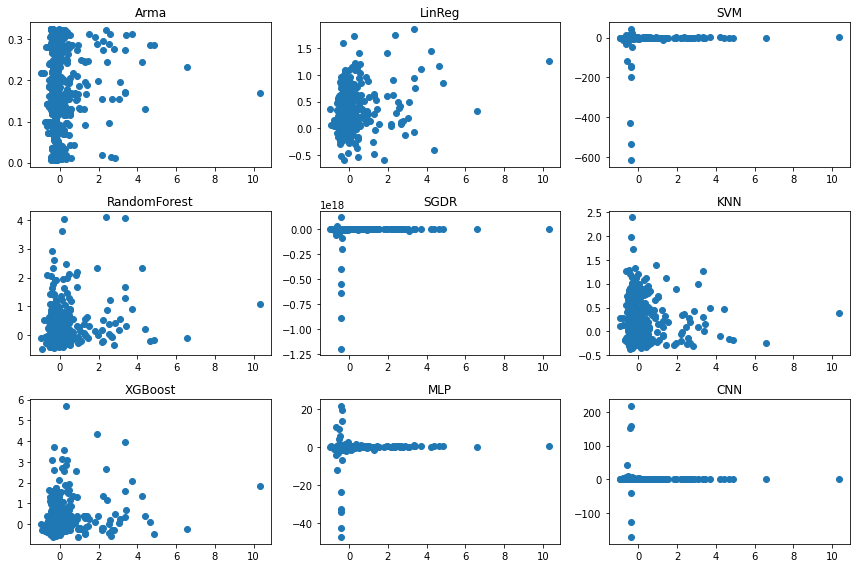

In [120]:
fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(12, 8))
axs[0, 0].scatter(y_test, arima_preds)
axs[0,0].title.set_text('Arma')

axs[0, 1].scatter(y_test, y_test_pred_lin)
axs[0,1].title.set_text('LinReg')

axs[0, 2].scatter(y_test, y_test_pred_svm)
axs[0,2].title.set_text('SVM')

axs[1, 0].scatter(y_test, y_test_pred_rf)
axs[1,0].title.set_text('RandomForest')

axs[1, 1].scatter(y_test, y_test_pred_sgdr)
axs[1,1].title.set_text('SGDR')

axs[1, 2].scatter(y_test, knn_y_pred)
axs[1,2].title.set_text('KNN')

axs[2, 0].scatter(y_test, xgb_preds)
axs[2,0].title.set_text('XGBoost')

axs[2, 1].scatter(y_test, mlp_valid_pred)
axs[2,1].title.set_text('MLP')

axs[2, 2].scatter(y_test, cnn_valid_pred)
axs[2,2].title.set_text('CNN')

fig.tight_layout()
fig.savefig('scatter-resids.png')

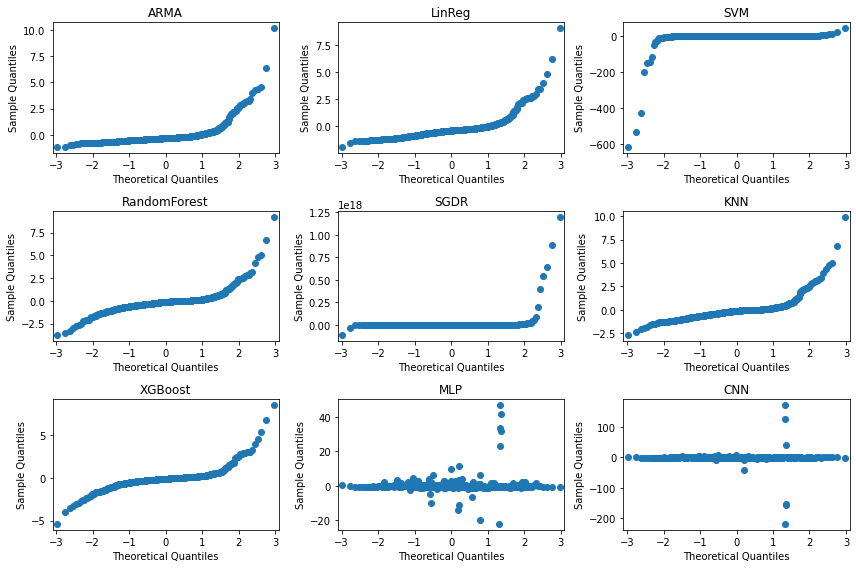

In [121]:
# QQPlots
fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(12, 8))
arima_resids = np.array([y_test[i]-arima_preds[i] for i in range(len(arima_preds))])
qqplot(arima_resids, ax=axs[0,0])
axs[0,0].title.set_text('ARMA')

lin_resids = np.array([y_test[i]-y_test_pred_lin[i] for i in range(len(y_test_pred_lin))])
qqplot(lin_resids, ax=axs[0,1])
axs[0,1].title.set_text('LinReg')

svm_resids = np.array([y_test[i]-y_test_pred_svm[i] for i in range(len(y_test_pred_svm))])
qqplot(y_test_pred_svm, ax=axs[0,2])
axs[0,2].title.set_text('SVM')

rf_resids = np.array([y_test[i]-y_test_pred_rf[i] for i in range(len(y_test_pred_rf))])
qqplot(rf_resids, ax=axs[1,0])
axs[1,0].title.set_text('RandomForest')

sgdr_resids = np.array([y_test[i]-y_test_pred_sgdr[i] for i in range(len(y_test_pred_sgdr))])
qqplot(sgdr_resids, ax=axs[1,1])
axs[1,1].title.set_text('SGDR')

knn_resids = np.array([y_test[i]-knn_y_pred[i] for i in range(len(knn_y_pred))])
qqplot(knn_resids, ax=axs[1,2])
axs[1,2].title.set_text('KNN')

xgb_resids = np.array([y_test[i]-xgb_preds[i] for i in range(len(xgb_preds))])
qqplot(xgb_resids, ax=axs[2,0])
axs[2,0].title.set_text('XGBoost')

mlp_resids = np.array([y_test[i]-mlp_valid_pred[i] for i in range(len(mlp_valid_pred))])
qqplot(mlp_resids, ax=axs[2,1])
axs[2,1].title.set_text('MLP')

cnn_resids = np.array([y_test[i]-cnn_valid_pred[i] for i in range(len(cnn_valid_pred))])
qqplot(cnn_resids, ax=axs[2,2])
axs[2,2].title.set_text('CNN')

fig.tight_layout()
fig.savefig('qq-resids.png')